In [25]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree 
from sklearn.ensemble import ExtraTreesClassifier      #- random trees 
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier 
from sklearn.ensemble import GradientBoostingClassifier #- GBM classfier 

# -- we need these to make our pipelines 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

# -- we need these to evaluate our models 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

# -- categorical encoders -- 
import category_encoders as ce 


# -- need this to render charts in notebook -- 
%matplotlib inline


In [26]:
df = pd.read_csv("./data/adult.csv",na_values="?")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [27]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


In [28]:
## Convert income to a 0 / 1 
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: income, dtype: float64

In [29]:
train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))

train pct: 70.00%
test  pct: 30.00%


In [30]:
# 1. Split features into categorical and numeric 
target = 'income'

numeric_features = ['age',
                    "fnlwgt", 
                    "educational_num",
                    "capital_gain",
                    "capital_loss",
                    "hours_per_week"]

categorical_features = ["gender",
                        "relationship",
                        "marital_status",
                        "workclass",
                        "occupation",
                        "education"] 

feature_names = numeric_features + categorical_features

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   32.0s finished


Best parameter (CV auc=nan):
{'classifier__n_estimators': 20, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1}


--- Training & Test Performance ---
(Training):
Accuracy 0.888
AUC.     0.947
(Test):
Accuracy 0.864
AUC.     0.918


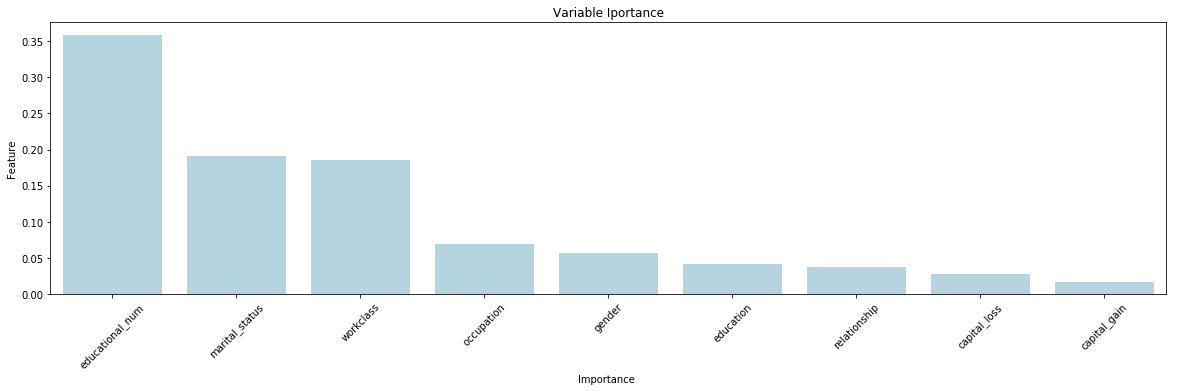

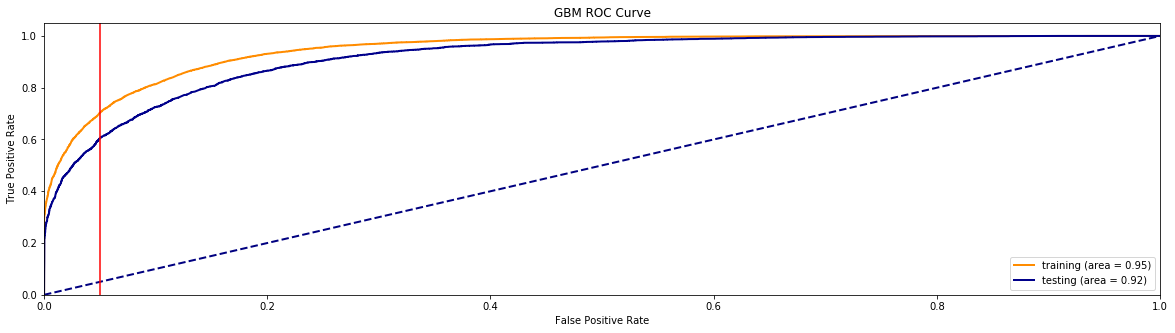

--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.33       0.72
1  0.02  0.43       0.64
2  0.03  0.49       0.59
3  0.04  0.54       0.54
4  0.05  0.58       0.51




In [31]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

def model_gbm_fit(param_grid):
    
    # -- define pipeline --
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('trgenc',  ce.TargetEncoder(smoothing = 2))  
    ])

    numerical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numeric_features)
        ])

    model_pipeline = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', GradientBoostingClassifier())
    ])
    
    
    # -- setup grid search -- 
    gbm_model = RandomizedSearchCV(model_pipeline, param_grid, n_jobs=-1, verbose=3, cv=3, scoring="roc_auc", refit=True)
    # -- fit grid search --
    gbm_model.fit(train[numeric_features + categorical_features], train[target])
    # -- print results -- 
    print("Best parameter (CV auc=%0.3f):" % gbm_model.best_score_)
    print(gbm_model.best_params_)
    print("\n")
    
    # -- assess best model, notice refit=True -- 
    train['.pred'] = gbm_model.predict(train[numeric_features + categorical_features])
    train['.prob'] = gbm_model.predict_proba(train[numeric_features + categorical_features])[:,1]
    train_probabilites = gbm_model.predict_proba(train[numeric_features + categorical_features])
    train_fpr, train_tpr, train_thr= roc_curve(train[target], train_probabilites[:,1])
    
    print("--- Training & Test Performance ---")
    print("(Training):")
    print("Accuracy %0.3f" % accuracy_score(train[target], train['.pred']))
    print("AUC.     %0.3f" % auc(train_fpr,train_tpr))
    
    test['.pred'] = gbm_model.predict(test[numeric_features + categorical_features])
    test['.prob'] = gbm_model.predict_proba(test[numeric_features + categorical_features])[:,1]
    test_probabilites = gbm_model.predict_proba(test[numeric_features + categorical_features])
    test_fpr, test_tpr, test_thr = roc_curve(test[target], test_probabilites[:,1])
    
    print("(Test):")
    print("Accuracy %0.3f" % accuracy_score(test[target], test['.pred']))
    print("AUC.     %0.3f" % auc(test_fpr,test_tpr))
    
    importance =  gbm_model.best_estimator_.named_steps["classifier"].feature_importances_
    
    
    
    feature_imp ={}
    for i,v in enumerate(importance):
        feature_imp[feature_names[i]] = v
        
     # make the dictionary a data frame 
    feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                         columns=['importance'])

    # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
    feature_imp = (feature_imp
                   .reset_index()
                   .rename(columns={'index':'feature'})
                   .sort_values('importance',ascending=False)
                   .query('importance > 0.01'))

    # -- plot that 
    plt.figure(figsize=(20,5))
    sns.barplot(y="importance", x="feature", data=feature_imp, color="lightblue")
    plt.title( 'Variable Iportance')
    plt.ylabel('Feature')
    plt.xlabel('Importance ')
    plt.xticks(rotation=45)
    plt.show()
    
    # -- make ROC charts 
    #- 5. FPR from 1 - 5% 
    model_stat = pd.concat([
        pd.DataFrame(test_fpr).rename(columns={0:'fpr'}),
        pd.DataFrame(test_tpr).rename(columns={0:'tpr'}),
        pd.DataFrame(test_thr).rename(columns={0:'threshold'})
        ],axis=1
        ).round(decimals=2)
   
    # - just get 1% FPR increments o
    m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()]    
    
    #- 3. get auc and threshold for train and test 
    train_auc = auc( train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    #- 6. plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=2, label='training (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='darkblue',
             lw=2, label='testing (area = %0.2f)' % test_auc)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axvline(x= 0.05,  color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'GBM ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print("--- TEST score thresholds ---")
    print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.05)].reset_index(drop=True))
    print("\n")
    
    
    return gbm_model, train , test  

param_grid = {
            'classifier__learning_rate':[0.01, 0.025, 0.05, 0.1, 0.15, 0.2],
            'classifier__n_estimators': [20,30],
            'classifier__max_depth': [5, 10],
            'classifier__min_samples_leaf': [2,4]
    }

gbm, train, test  = model_gbm_fit(param_grid)


In [32]:
train.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,.pred,.prob
44498,29,Private,119052,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,Black,Female,0,0,40,United-States,0,0,0.036228
10238,33,Private,198613,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0,0,0.207360
22868,22,Private,290504,HS-grad,9,Never-married,Other-service,Other-relative,White,Male,0,0,40,United-States,0,0,0.033619
16504,54,Private,176681,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,20,United-States,0,0,0.140617
37656,25,Private,306908,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States,1,1,0.724882


In [40]:
from sklearn.tree import DecisionTreeRegressor 
# -- this is your pipeline based model -- 
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

dt_explainer = Pipeline([
    ('preprocess', preprocessing),
    ('explainer', DecisionTreeRegressor(max_depth = 5,
                                          min_samples_leaf = 2,
                                          random_state=42))
])

dt_explainer = dt_explainer.fit(train[categorical_features + numeric_features], train[".prob"])
dt_explainer

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [41]:
# -- get the feature names from the transform, remember we've now made a number of new columns by doing one-hot-encoding --
categorical_pipe.fit_transform(train[categorical_features])
transformed_categorical = categorical_pipe['onehot'].get_feature_names(categorical_features).tolist()

# -- creates one list of all the feature names. 
feature_names =  transformed_categorical + numeric_features


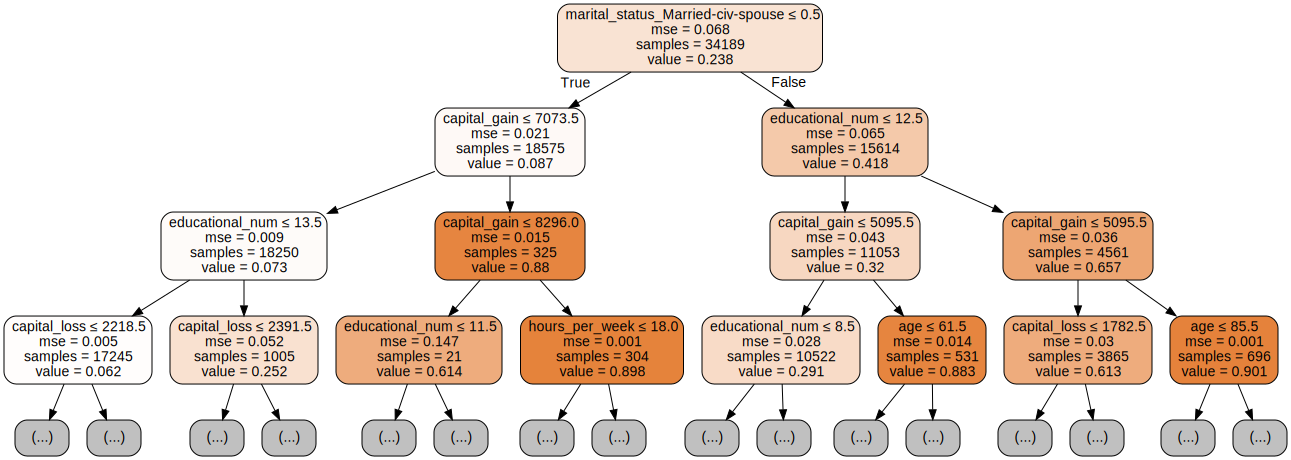

In [42]:
# -- chart of tree 
import graphviz 
from sklearn.tree import export_text                   #- export tree as text rules 
from sklearn import tree

dot_data = tree.export_graphviz(dt_explainer['explainer'], 
                                out_file=None,
            feature_names = feature_names,
            max_depth = 3,
            filled=True, 
            rounded=True,  
            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [43]:
# -- Text based Rules for your Tree 
r = export_text(dt_explainer['explainer'], 
                feature_names= feature_names)
print(r)

|--- marital_status_Married-civ-spouse <= 0.50
|   |--- capital_gain <= 7073.50
|   |   |--- educational_num <= 13.50
|   |   |   |--- capital_loss <= 2218.50
|   |   |   |   |--- hours_per_week <= 42.50
|   |   |   |   |   |--- value: [0.05]
|   |   |   |   |--- hours_per_week >  42.50
|   |   |   |   |   |--- value: [0.11]
|   |   |   |--- capital_loss >  2218.50
|   |   |   |   |--- capital_loss <= 2391.50
|   |   |   |   |   |--- value: [0.32]
|   |   |   |   |--- capital_loss >  2391.50
|   |   |   |   |   |--- value: [0.62]
|   |   |--- educational_num >  13.50
|   |   |   |--- capital_loss <= 2391.50
|   |   |   |   |--- hours_per_week <= 44.50
|   |   |   |   |   |--- value: [0.17]
|   |   |   |   |--- hours_per_week >  44.50
|   |   |   |   |   |--- value: [0.35]
|   |   |   |--- capital_loss >  2391.50
|   |   |   |   |--- capital_loss <= 2458.00
|   |   |   |   |   |--- value: [0.84]
|   |   |   |   |--- capital_loss >  2458.00
|   |   |   |   |   |--- value: [0.88]
|   |---

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
train[".explain"] = dt_explainer.predict(train)
train.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,.pred,.prob,.explain
44498,29,Private,119052,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,Black,Female,0,0,40,United-States,0,0,0.036228,0.048103
10238,33,Private,198613,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0,0,0.207360,0.309248
22868,22,Private,290504,HS-grad,9,Never-married,Other-service,Other-relative,White,Male,0,0,40,United-States,0,0,0.033619,0.048103
16504,54,Private,176681,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,20,United-States,0,0,0.140617,0.309248
37656,25,Private,306908,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States,1,1,0.724882,0.603950


In [45]:
print("(Explainer Accuracy):")
print("mse     %0.3f" % mean_squared_error(train[".prob"], train[".explain"]))
print("r_2     %0.3f" % r2_score(train[".prob"], train[".explain"]))

(Explainer Accuracy):
mse     0.010
r_2     0.845


## LOCO example 

In [21]:
# calculate LOCO for each variable
print('Calculating LOCO contributions ...')
test_loco = test[numeric_features + categorical_features +[".pred", ".prob"]].copy()
y_mean = test['.prob'].mean()
for k, i in enumerate(test[numeric_features + categorical_features]):
    print(i)
    # train and predict with x_i set to missing
    if i in numeric_features:
        test_loco[i] = np.nan
    else:
        test_loco[i] = ""
        
    test_loco[i] = gbm.predict_proba(test_loco[numeric_features + categorical_features])[:,1]
    
    test_loco[i] = test['.prob'] - test_loco[i] 

    

print("done...")

Calculating LOCO contributions ...
age
fnlwgt
educational_num
capital_gain
capital_loss
hours_per_week
gender
relationship
marital_status
workclass
occupation
education
done...


In [22]:
test_loco.head()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week,gender,relationship,marital_status,workclass,occupation,education,.pred,.prob
23797,0.088271,0.130493,0.045250,0.080804,-0.041329,-0.050684,-0.038285,0.004574,0.004574,0.113707,0.113707,0.113707,0,0.161204
1780,-0.016943,0.003990,-0.013675,0.007178,0.005146,0.005043,0.005146,0.004026,0.005216,-0.219863,-0.033920,-0.033920,0,0.013576
30379,-0.008659,0.005632,0.005288,0.007611,0.004206,0.003823,0.004206,0.003893,0.003893,-0.187824,-0.035407,-0.035407,0,0.012089
39086,-0.003565,0.001153,0.000777,0.002974,-0.000310,-0.000694,-0.000310,0.000029,0.000330,-0.030183,-0.039887,-0.039887,0,0.007609
10903,0.932429,0.958700,0.941092,0.966522,0.955840,0.946486,0.938216,0.940087,0.976365,0.938092,0.938092,0.938092,1,0.985588


In [24]:
# scale contributions to sum to yhat - y_0
print('\nScaling contributions ...')
y_mean = test['.prob'].mean()
# scaler = (preds2['Y'] - y_mean) / preds2[numeric_features].sum(axis=1)
scaler = (test['.prob'] - y_mean) / test_loco[numeric_features + categorical_features].sum(axis=1)

test[numeric_features + categorical_features] = test_loco[numeric_features + categorical_features].multiply(scaler, axis=0) 
test.head()


Scaling contributions ...


,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,.pred,.prob
23797,-0.011757,-0.015144,-0.017380,-0.015144,-0.006027,-0.000609,-0.015144,-0.000609,White,0.005099,-0.010762,0.005505,0.006751,United-States,0,0,0.161204
1780,-0.013362,-0.173393,0.003147,-0.026751,-0.010785,0.004114,-0.026751,0.003175,White,0.004058,0.005661,0.004058,0.003977,United-States,0,0,0.013576
30379,-0.008492,-0.184205,0.005523,-0.034725,0.005186,0.003818,-0.034725,0.003818,White,0.004125,0.007465,0.004125,0.003749,United-States,0,0,0.012089
39086,-0.007444,-0.063030,0.002408,-0.083294,0.001622,0.000689,-0.083294,0.000061,Black,-0.000648,0.006210,-0.000648,-0.001450,United-States,0,0,0.007609
10903,0.061437,0.061810,0.063168,0.061810,0.062008,0.064332,0.061810,0.061942,White,0.061818,0.063683,0.062980,0.062363,United-States,1,1,0.985588


In [18]:
test[numeric_features +['.prob']]

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week,.prob
23797,0.144528,-0.180381,-0.026950,-0.105840,0.026355,0.067065,0.161204
1780,-0.172475,-0.260760,-0.400768,0.252602,0.181086,0.177464,0.013576
30379,0.001725,-0.046749,-0.045169,-0.065390,-0.035753,-0.033003,0.012089
39086,-0.578954,0.011396,0.095825,0.366879,-0.038280,-0.085684,0.007609
10903,0.000194,0.014312,0.018201,0.241381,0.237537,0.237537,0.985588
...,...,...,...,...,...,...,...
35338,-0.106184,-0.420452,-0.034366,0.020596,0.756574,-0.407518,0.045077
26458,0.003434,0.094373,0.118202,0.140143,0.134648,0.138951,0.866178
1620,0.000000,0.160235,0.147706,0.145031,0.107904,0.166585,0.963889
12787,-0.006563,0.013553,0.011382,0.015320,0.014264,0.014264,0.298649
